In [41]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
 # libmxnet.so 파일을 로드하지 못해서 발생한 것입니다. 
# 이는 MacOS와 MXNet의 호환성 문제일 가능성이 큽니다.
# 특히, **libmxnet.so**는 일반적으로 Linux 또는 Windows 환경에서 사용하는 .so(Shared Object) 파일로, MacOS에서는 Mach-O 형식으로 되어 있어야 하는데,
# 여기서는 libmxnet.so를 잘못된 형식으로 인식하고 있는 것 같습니다.
# 학습 시간의 확보를 위해 conda 를 추가적으로 설치하지 않으며 mxnet 의존성이 없는 sentencepiece 토크나이저를 직접 import 하여 사용하기로 결정
# from gluonnlp.data import SentencepieceTokenizer
import sentencepiece as spm

In [2]:
DATA_IN_PATH = './data_in/KOR'
TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
train_data =pd.read_csv(TRAIN_STS_DF, sep='\t', quoting=3)
train_data.head(10)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
5,main-captions,MSRvid,2012test,11,4.25,몇몇 남자들이 싸우고 있다.,두 남자가 싸우고 있다.
6,main-captions,MSRvid,2012test,12,0.50,남자가 담배를 피우고 있다.,남자가 스케이트를 타고 있다.
7,main-captions,MSRvid,2012test,13,1.60,남자가 피아노를 치고 있다.,남자가 기타를 연주하고 있다.
8,main-captions,MSRvid,2012test,14,2.20,한 남자가 기타를 치고 노래를 부르고 있다.,한 여성이 어쿠스틱 기타를 연주하고 노래를 부르고 있다.
9,main-captions,MSRvid,2012test,16,5.00,사람이 고양이를 천장에 던지고 있다.,사람이 고양이를 천장에 던진다.


In [3]:
print(f'전체 train_data 개수: {len(train_data)}')

전체 train_data 개수: 5749


In [5]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.head()

0             비행기가 이륙하고 있다.
1     한 남자가 큰 플루트를 연주하고 있다.
2    한 남자가 피자에 치즈를 뿌려놓고 있다.
3          세 남자가 체스를 하고 있다.
4        한 남자가 첼로를 연주하고 있다.
dtype: object

In [6]:
print(f'전체 문장 데이터의 개수: {len(train_set)}')

전체 문장 데이터의 개수: 11498


In [7]:
print(f"유일한 총 문장 수 : {len(np.unique(train_set))}")
print(f"반복해서 나타나는 문장의 수: {np.sum(train_set.value_counts() > 1)}")

유일한 총 문장 수 : 10383
반복해서 나타나는 문장의 수: 716


Text(0, 0.5, 'Number of sentence')

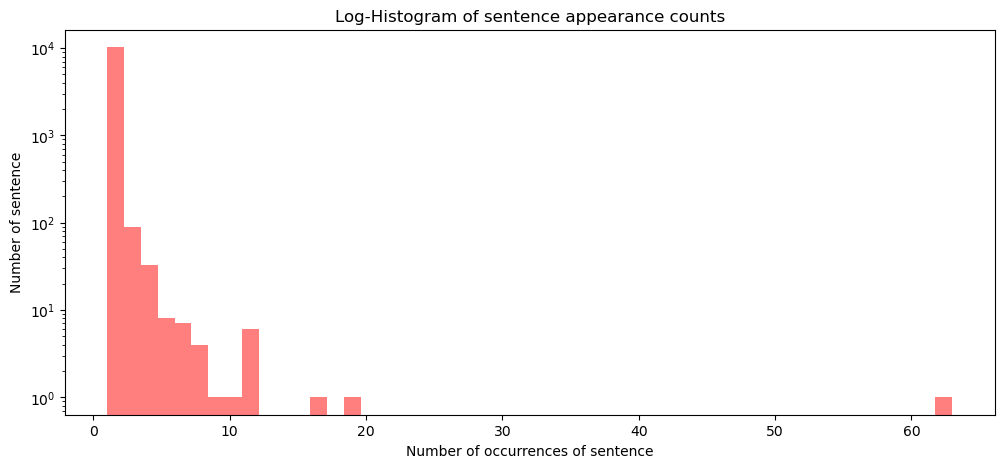

In [8]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [9]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 63
중복 최소 개수: 1
중복 평균 개수: 1.11
중복 표준편차: 0.81
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/4064846887.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_set.value_counts()],


{'whiskers': [<matplotlib.lines.Line2D at 0x16e456650>,
 'caps': [<matplotlib.lines.Line2D at 0x177610890>,
 'boxes': [<matplotlib.lines.Line2D at 0x16e47ba10>],
 'medians': [<matplotlib.lines.Line2D at 0x1775ca610>],
 'fliers': [<matplotlib.lines.Line2D at 0x1775ca050>],
 'means': [<matplotlib.lines.Line2D at 0x1775ca4d0>]}

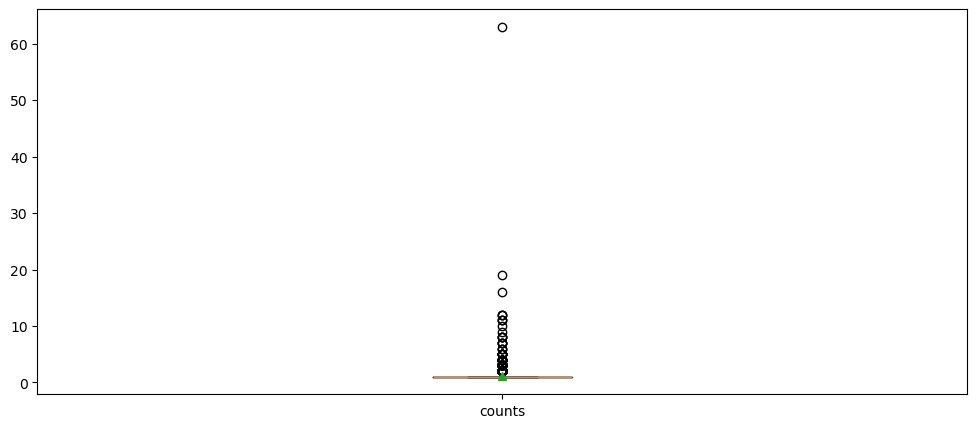

In [10]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

In [11]:
train_length = train_set.apply(len)

Text(0, 0.5, 'Probability')

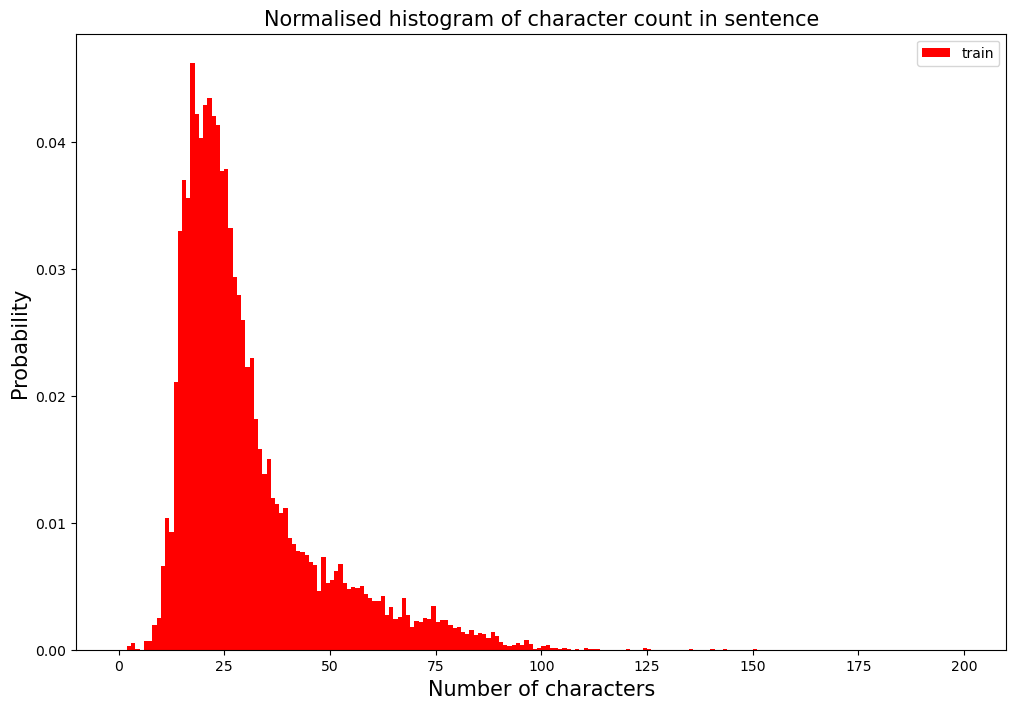

In [12]:
plt.figure(figsize=(12, 8))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [13]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 150
문장 길이 평균 값: 29.80
문장 길이 표준편차: 16.76
문장 길이 중간 값: 25.0
문장 길이 제 1 사분위: 19.0
문장 길이 제 3 사분위: 35.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/2968259792.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_length,


{'whiskers': [<matplotlib.lines.Line2D at 0x3008ff6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x3009104d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3008fee90>],
 'medians': [<matplotlib.lines.Line2D at 0x300911650>],
 'fliers': [<matplotlib.lines.Line2D at 0x3009127d0>],
 'means': [<matplotlib.lines.Line2D at 0x300911f10>]}

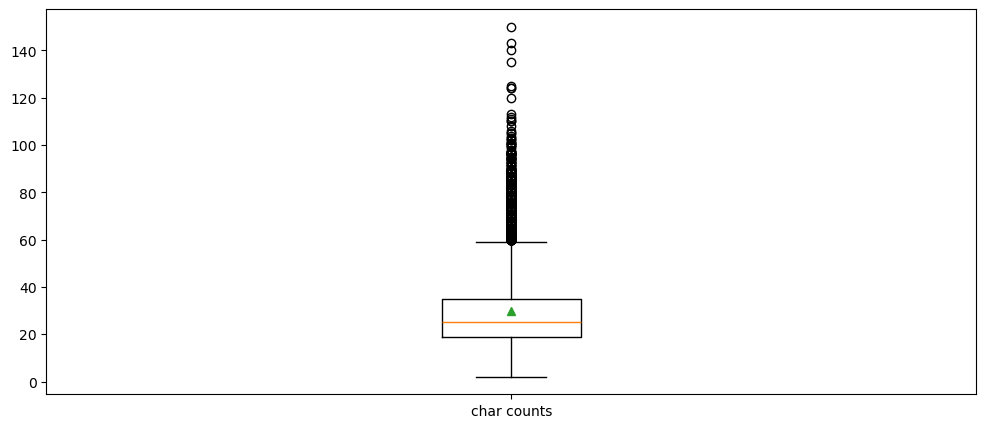

In [14]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

In [15]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Prabability')

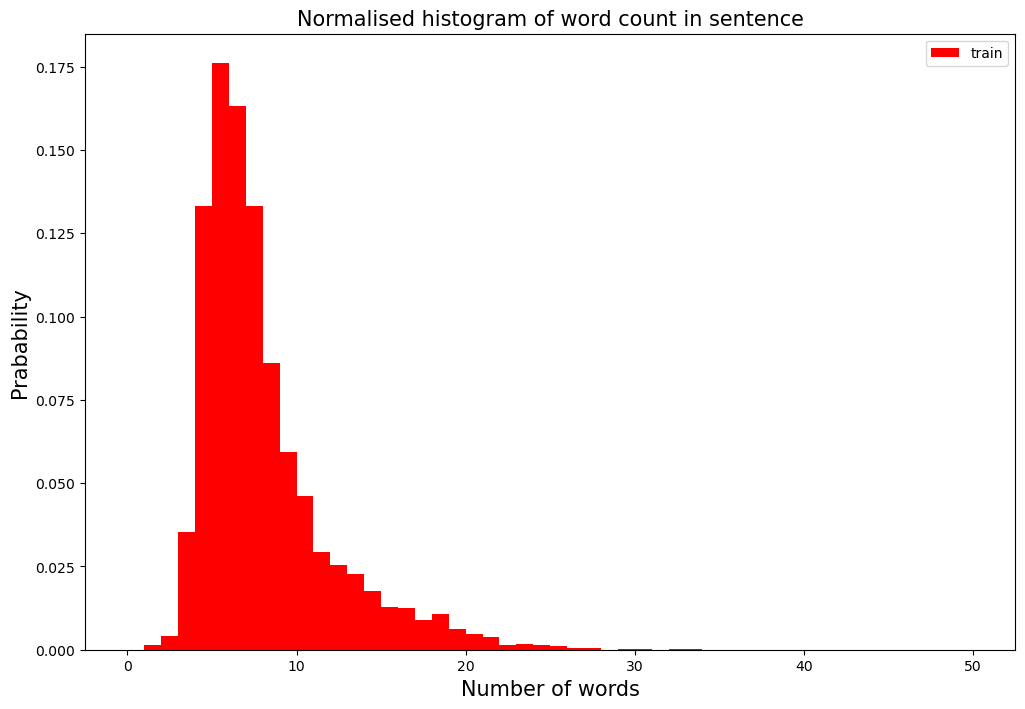

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [17]:
print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

문장 단어 개수 최대 값: 33
문장 단어 개수 평균 값: 7.50
문장 단어 개수 표준편차: 3.84
문장 단어 개수 중간 값: 6.0
문장 단어 개수 제 1 사분위: 5.0
문장 단어 개수 제 3 사분위: 9.0
문장 단어 개수 99 퍼센트: 21.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/2041540663.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_word_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x300a49190>,
 'caps': [<matplotlib.lines.Line2D at 0x300a4a3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3008d5350>],
 'medians': [<matplotlib.lines.Line2D at 0x300a4b490>],
 'fliers': [<matplotlib.lines.Line2D at 0x300a30d10>],
 'means': [<matplotlib.lines.Line2D at 0x300a4bc90>]}

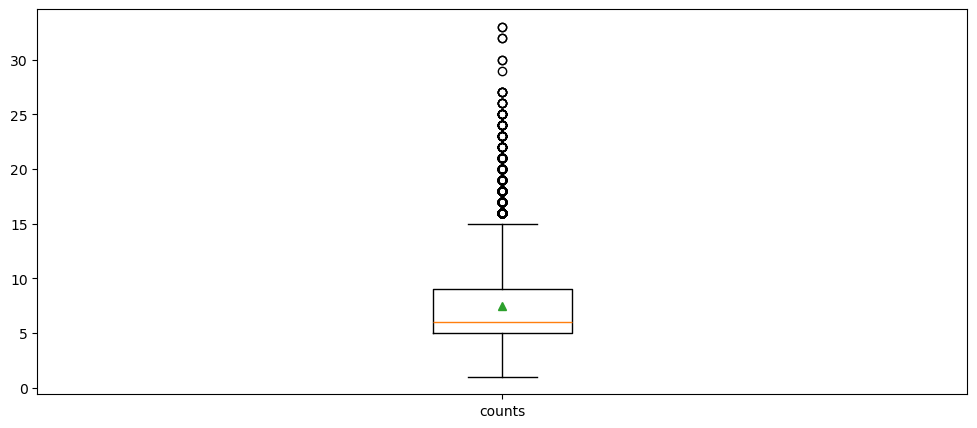

In [18]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

In [19]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개

In [21]:
print('물음표가있는 문장: {:.2f}%'.format(qmarks * 100))
print('마침표를 포함한 문장: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 문장: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 문장: {:.2f}%'.format(capitals * 100))
print('숫자가있는 문장: {:.2f}%'.format(numbers * 100))

물음표가있는 문장: 1.81%
마침표를 포함한 문장: 70.13%
첫 글자가 대문자 인 문장: 1.84%
대문자가있는 문장: 5.84%
숫자가있는 문장: 19.33%


In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
train_bert_token_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Prabability')

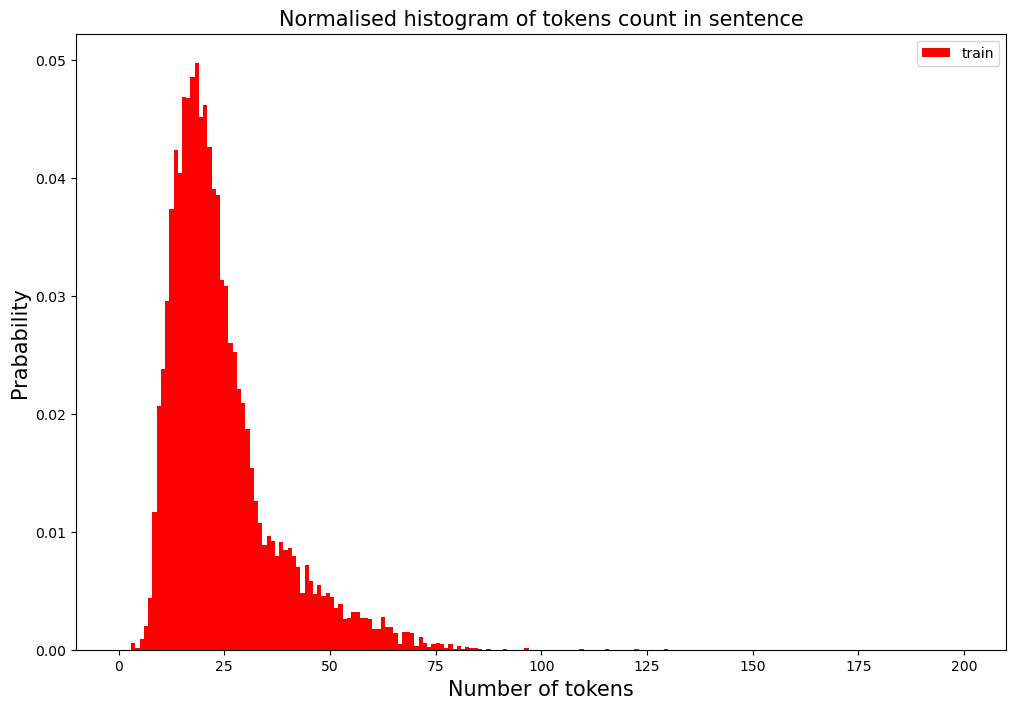

In [24]:
plt.figure(figsize=(12, 8))
plt.hist(train_bert_token_counts, bins=200, range=[0, 200], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [25]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 129
문장 tokens 개수 평균 값: 23.84
문장 tokens 개수 표준편차: 12.68
문장 tokens 개수 중간 값: 21.0
문장 tokens 개수 제 1 사분위: 15.0
문장 tokens 개수 제 3 사분위: 28.0
문장 tokens 개수 99 퍼센트: 67.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/3259379739.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_bert_token_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x301518610>,
 'caps': [<matplotlib.lines.Line2D at 0x301519790>,
 'boxes': [<matplotlib.lines.Line2D at 0x30153a1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x30151a910>],
 'fliers': [<matplotlib.lines.Line2D at 0x30151b850>],
 'means': [<matplotlib.lines.Line2D at 0x30151b190>]}

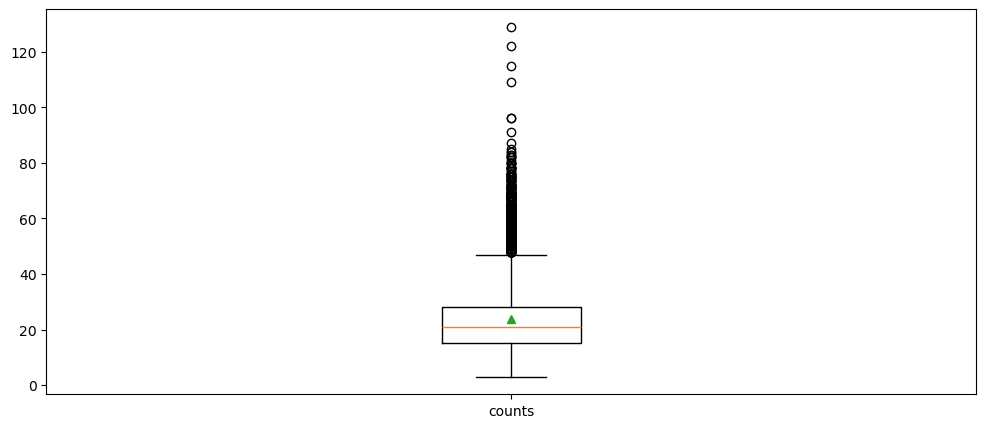

In [26]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
             labels=['counts'],
             showmeans=True)

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
train_bert_token_cased_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Prabability')

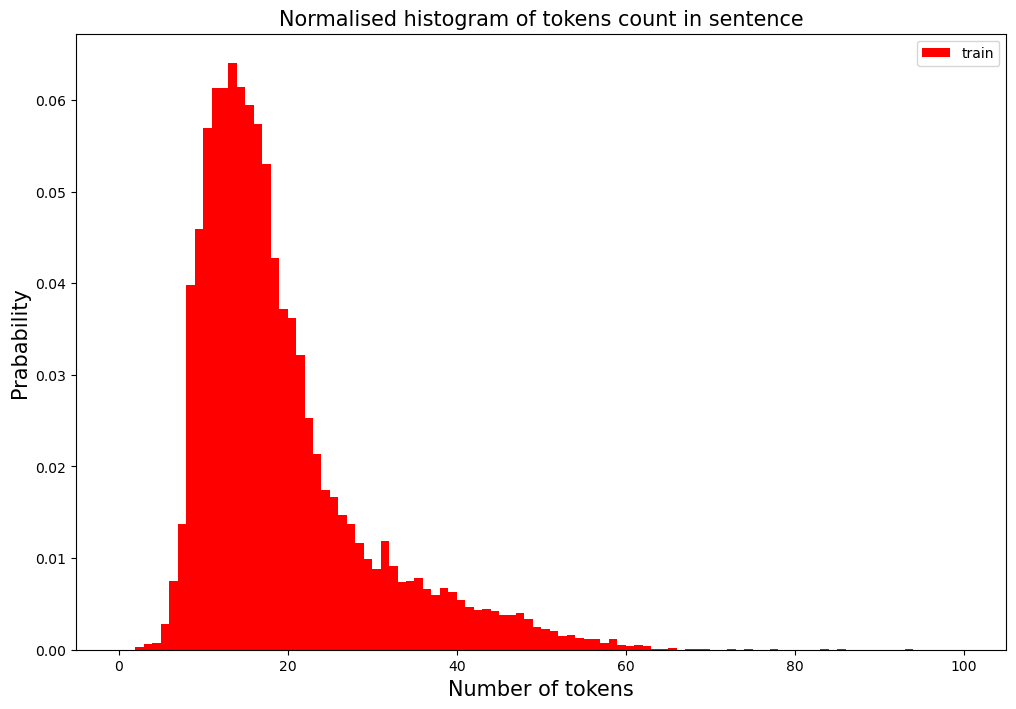

In [29]:
plt.figure(figsize=(12, 8))
plt.hist(train_bert_token_cased_counts, bins=100, range=[0, 100], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [30]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_cased_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_cased_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_cased_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_cased_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_cased_counts, 99)))

문장 tokens 개수 최대 값: 102
문장 tokens 개수 평균 값: 18.74
문장 tokens 개수 표준편차: 10.12
문장 tokens 개수 중간 값: 16.0
문장 tokens 개수 제 1 사분위: 12.0
문장 tokens 개수 제 3 사분위: 22.0
문장 tokens 개수 99 퍼센트: 53.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/1625359504.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_bert_token_cased_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x3046f6c90>,
 'caps': [<matplotlib.lines.Line2D at 0x3046f7e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x16e55a1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x301d83050>],
 'fliers': [<matplotlib.lines.Line2D at 0x301d82050>],
 'means': [<matplotlib.lines.Line2D at 0x301d82790>]}

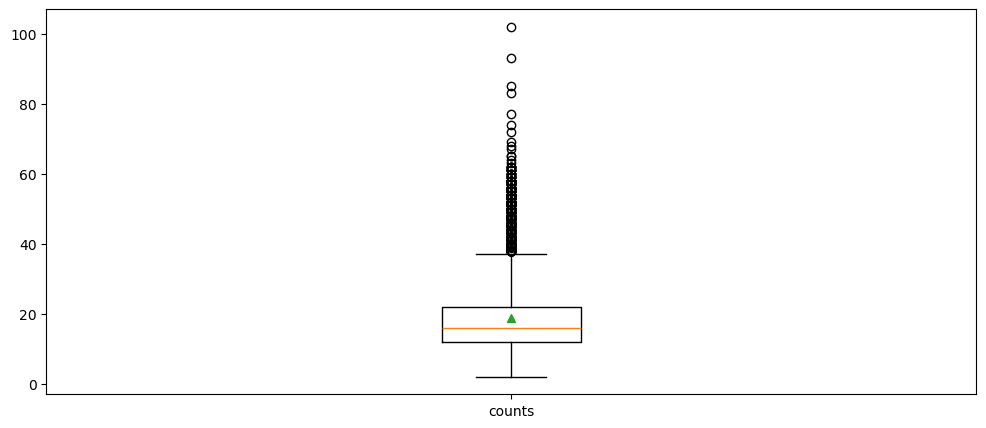

In [31]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_cased_counts,
             labels=['counts'],
             showmeans=True)

In [56]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

# SentencePieceProcessor 객체 생성
tokenizer = spm.SentencePieceProcessor(TOKENIZER_PATH)

# 토크나이저 모델 로드
tokenizer.load(TOKENIZER_PATH)

True

In [62]:
# 토큰의 개수를 계산하려면 encode_as_pieces 메서드를 사용합니다.
train_sentencepeice_counts = train_set.apply(lambda x: len(tokenizer.encode_as_pieces(x)))

Text(0, 0.5, 'Prabability')

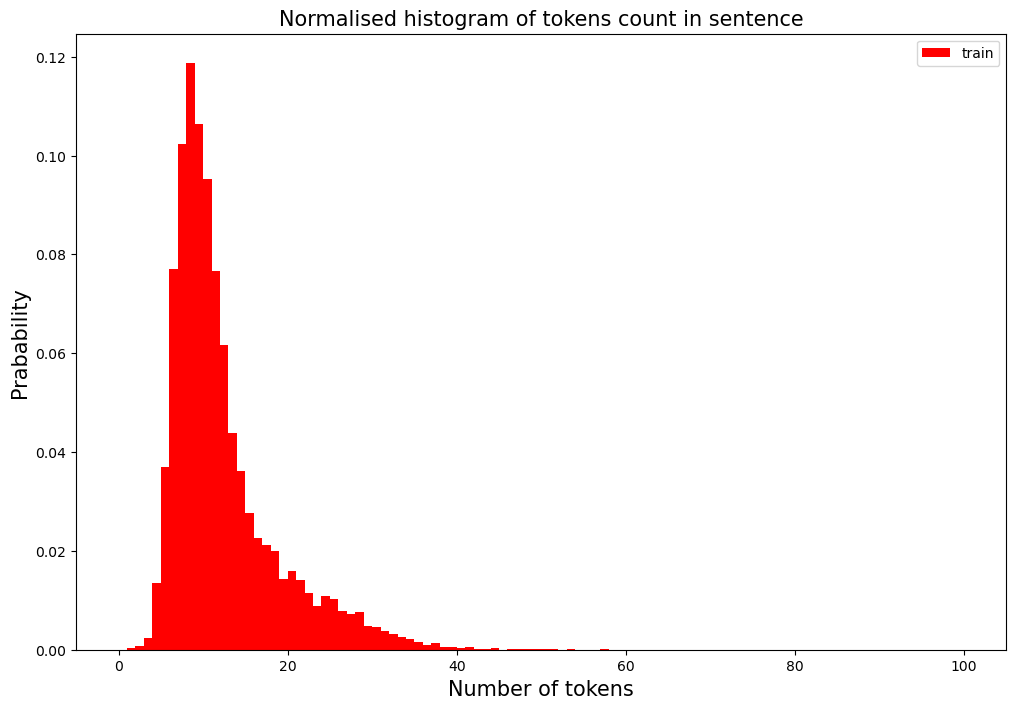

In [63]:
plt.figure(figsize=(12, 8))
plt.hist(train_sentencepeice_counts, bins=100, range=[0, 100], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [64]:

print('문장 tokens 개수 최대 값: {}'.format(np.max(train_sentencepeice_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_sentencepeice_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_sentencepeice_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_sentencepeice_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_sentencepeice_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_sentencepeice_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_sentencepeice_counts, 99)))

문장 tokens 개수 최대 값: 57
문장 tokens 개수 평균 값: 11.86
문장 tokens 개수 표준편차: 6.36
문장 tokens 개수 중간 값: 10.0
문장 tokens 개수 제 1 사분위: 8.0
문장 tokens 개수 제 3 사분위: 14.0
문장 tokens 개수 99 퍼센트: 33.0


/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_52131/178511544.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_sentencepeice_counts,


{'whiskers': [<matplotlib.lines.Line2D at 0x3059c1ad0>,
 'caps': [<matplotlib.lines.Line2D at 0x3059c2cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x30599a1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x3059c3d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x3059d0c90>],
 'means': [<matplotlib.lines.Line2D at 0x3059d0550>]}

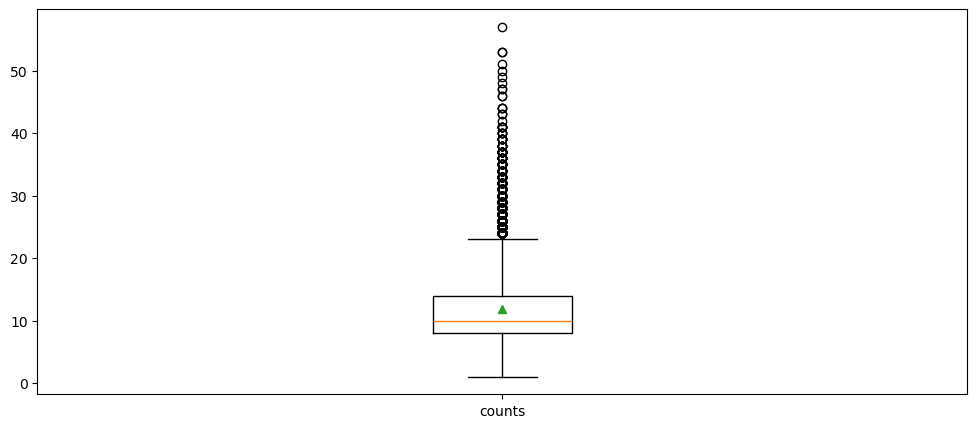

In [65]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_sentencepeice_counts,
             labels=['counts'],
             showmeans=True)

(-0.5, 799.5, 599.5, -0.5)

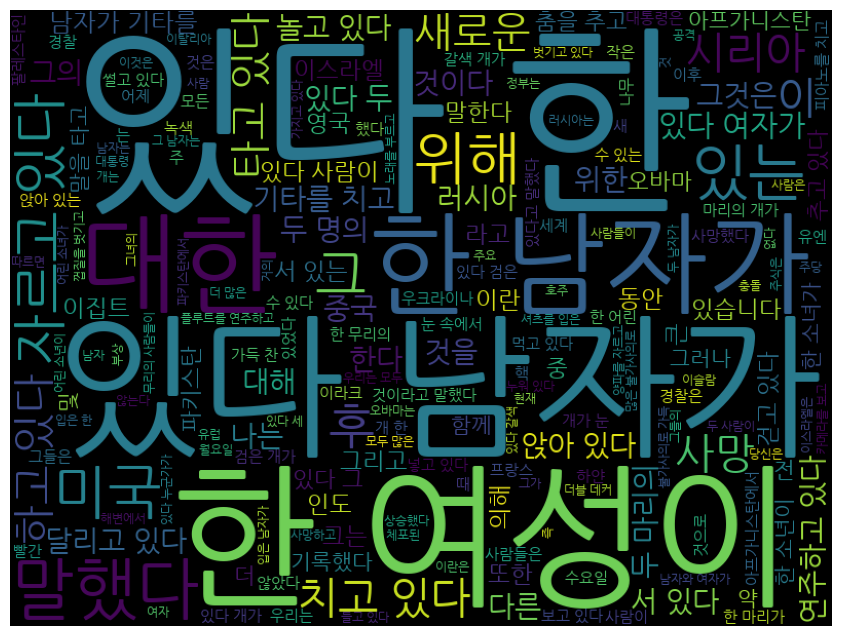

In [67]:
from wordcloud import WordCloud

font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(12, 8))
plt.imshow(cloud)
plt.axis('off')

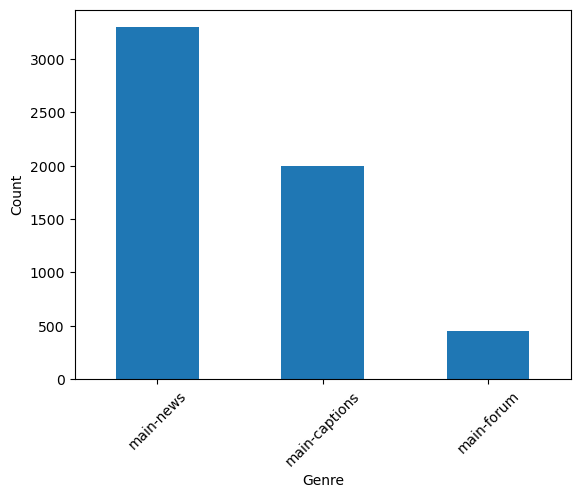

In [75]:
train_data.genre.value_counts().plot(kind='bar')
plt.xticks(rotation=45)  # x축 눈금 라벨을 45도 회전
plt.xlabel('Genre')  # x축의 이름 설정
plt.ylabel('Count')  # y축의 이름 설정
plt.show()  # 그래프 표시


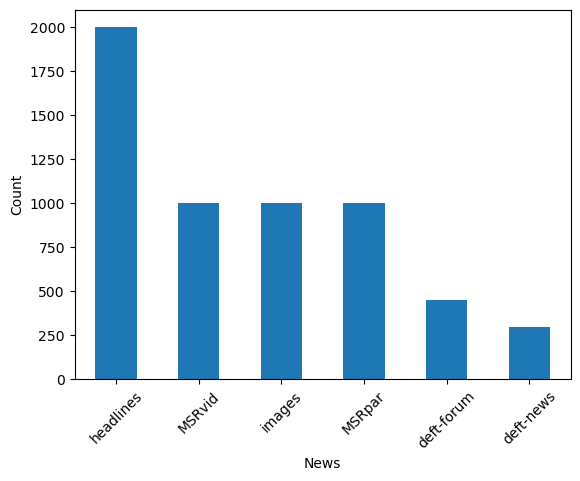

In [78]:
train_data.filename.value_counts().plot(kind='bar')
plt.xticks(rotation=45)  # x축 눈금 라벨을 45도 회전
plt.xlabel('News')  # x축의 이름 설정
plt.ylabel('Count')  # y축의 이름 설정
plt.show()  # 그래프 표시

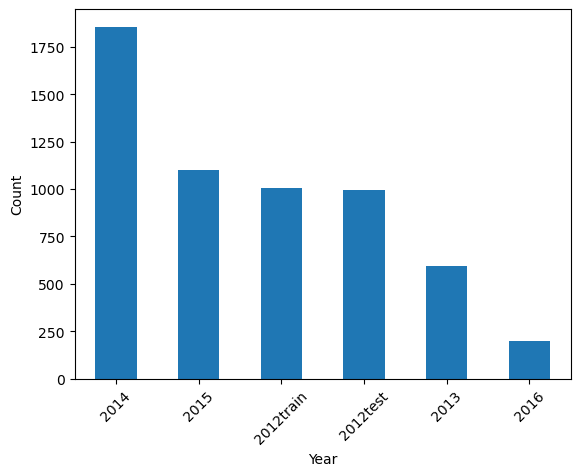

In [80]:
train_data.year.value_counts().plot(kind='bar')
plt.xticks(rotation=45)  # x축 눈금 라벨을 45도 회전
plt.xlabel('Year')  # x축의 이름 설정
plt.ylabel('Count')  # y축의 이름 설정
plt.show()  # 그래프 표시

<Axes: >

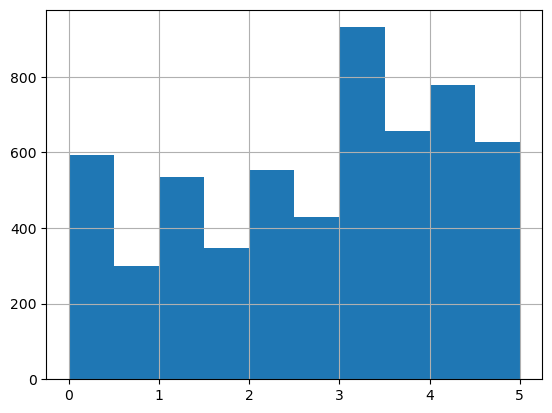

In [81]:
train_data.score.hist()